In [1]:
# Imorting necessary libraries
from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras import Model, Sequential
from tensorflow.keras import layers 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.metrics as metrics

# Setting some variables for plotting via matplotlib
plt.rcParams["figure.figsize"] = (10, 10)
#plt.rcParams["figure.figsize"] = (5, 5)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rc('lines', linewidth=3)
plt.rc('font', size=15)

In [2]:
import random

random.seed(10)
np.random.seed(10)
tf.random.set_seed(10)

In [3]:
# Find and load normal image directories into a list
directory_test = '../../ADV/hacker-4-layer-attack/JSMA_cv2-0.03-0.82051283-0.17948718/NORMAL/'
#directory_test = '../../chest_xray/D1/test/NORMAL/'
image_paths_norm = sorted(list(paths.list_images(directory_test)))

# Declare a normal label list
labels_norm = ['Normal'] * len(image_paths_norm)

In [4]:
# Find and load pneumonia image directories into a list
directory_test_pn = '../../ADV/hacker-4-layer-attack/JSMA_cv2-0.03-0.82051283-0.17948718/PNEUMONIA/'
#directory_test_pn = '../../chest_xray/D1/test//PNEUMONIA/'

image_paths_pn = sorted(list(paths.list_images(directory_test_pn)))

# Declare a pneumonia label list for binary
labels_pn = ['Pneumonia'] * len(image_paths_pn)

# Merge the image and label lists together and turn them into NumPy arrays
image_paths = np.array(image_paths_norm + image_paths_pn)
labels = np.concatenate((labels_norm, labels_pn))

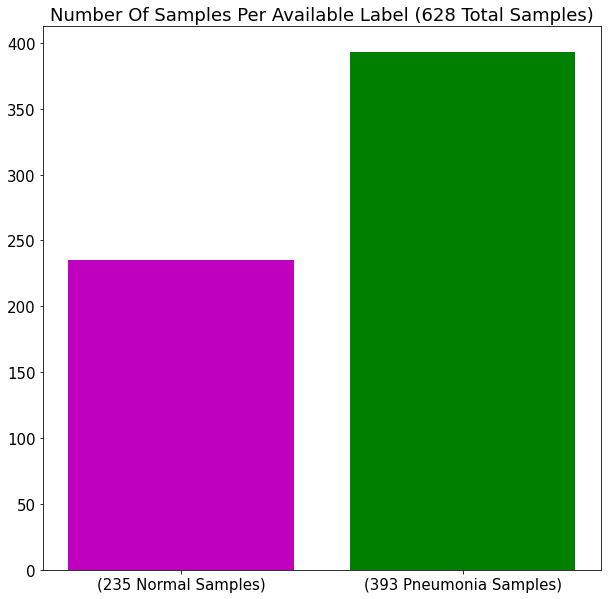

In [5]:
# Plot a bar with numbers of normal and pneumonia diagnoses
plt.bar([1, 2], height=[len(labels_norm), len(labels_pn)], 
        tick_label=['({0:d} Normal Samples)'.format(len(labels_norm)), 
                    '({0:d} Pneumonia Samples)'.format(len(labels_pn))], 
        color=['m', 'g'])

plt.title('Number Of Samples Per Available Label ({0:d} Total Samples)'.
          format(len(labels_norm) + len(labels_pn)))

plt.show()

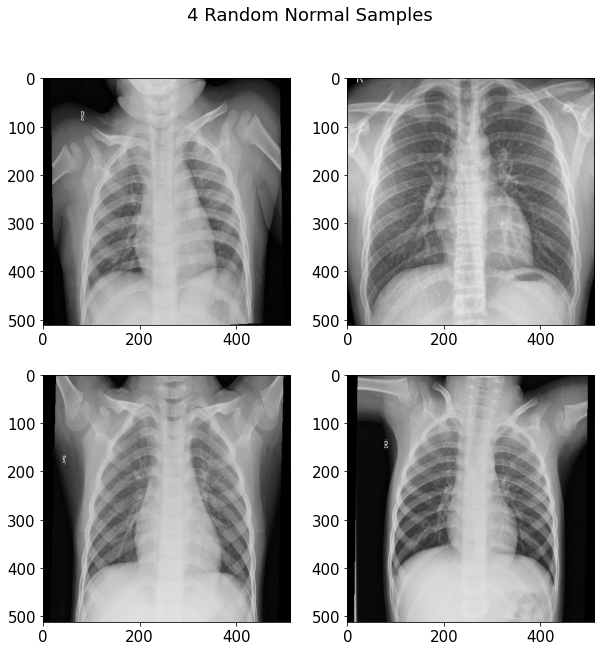

In [6]:
hyper_dimension = 512

# Build a 2 x 2 figure
rows, columns = 2, 2
fig, axes = plt.subplots(rows, columns)

# Choose random indices for image selection
norm_indices = np.random.choice(len(image_paths_norm), rows * columns)
pn_indices = np.random.choice(len(image_paths_pn), rows * columns)

# Make a list with images to plot
imgs_to_plot_norm = [image_paths_norm[i] for i in norm_indices]
imgs_to_plot_pn = [image_paths_pn[i] for i in pn_indices]

# Variable used for indending through the image list
current_index = 0

# Set figure title
fig.suptitle('4 Random Normal Samples')

# Plot normal images
for i in range(rows):
    for j in range(columns):
        img = load_img(imgs_to_plot_norm[current_index])        
        axes[i, j].imshow(img)
        #axes[i, j].set_xticks([])
        #axes[i, j].set_yticks([])
        #axes[i, j].axis('off')
        current_index +=1
        
plt.show()

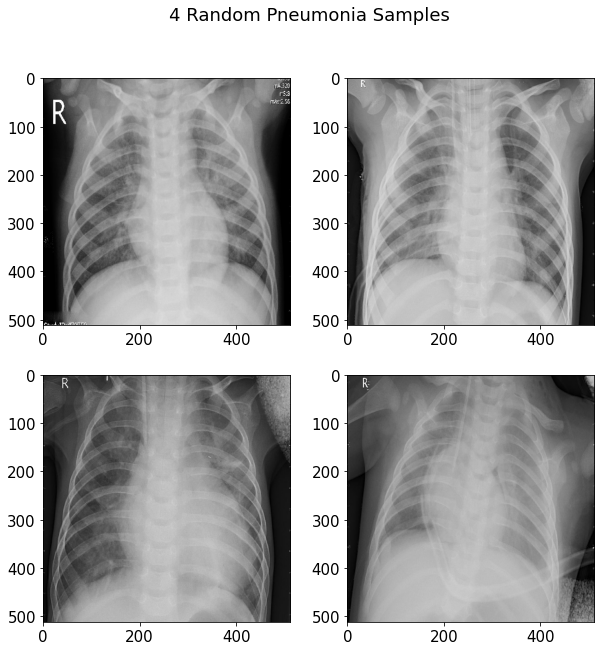

In [7]:
fig, axes = plt.subplots(rows, columns)

current_index = 0

# Set figure title
fig.suptitle('4 Random Pneumonia Samples')

# Plot pneumonia images
for i in range(rows):
    for j in range(columns):
        img = load_img(imgs_to_plot_pn[current_index])        
        axes[i, j].imshow(img)
        #axes[i, j].set_xticks([])
        #axes[i, j].set_yticks([])
        current_index +=1
        
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

# Divide the image path & label arrays into train & test sets. This is done without loading images to save memory
X_train_dir, X_test_dir, y_train, y_test = \
                                           train_test_split(image_paths, labels, test_size=0.9)


I will be feeding the data into the model via an *ImageDataGenerator* object. However, because we have image paths rather than image arrays, we can't use the *flow* method. Instead, we have to use the *flow_from_dataframe* method, which requires DataFrames containing image paths under the "filename" column and labels under the "class" column.

Below, we create DataFrames for each of our sets.

In [9]:
test_df = pd.DataFrame(np.transpose([X_test_dir, y_test]), 
                       columns=['filename', 'class'])

print(test_df)

                                              filename      class
0    ../../ADV/hacker-4-layer-attack/JSMA_cv2-0.03-...     Normal
1    ../../ADV/hacker-4-layer-attack/JSMA_cv2-0.03-...     Normal
2    ../../ADV/hacker-4-layer-attack/JSMA_cv2-0.03-...  Pneumonia
3    ../../ADV/hacker-4-layer-attack/JSMA_cv2-0.03-...  Pneumonia
4    ../../ADV/hacker-4-layer-attack/JSMA_cv2-0.03-...  Pneumonia
..                                                 ...        ...
561  ../../ADV/hacker-4-layer-attack/JSMA_cv2-0.03-...     Normal
562  ../../ADV/hacker-4-layer-attack/JSMA_cv2-0.03-...  Pneumonia
563  ../../ADV/hacker-4-layer-attack/JSMA_cv2-0.03-...     Normal
564  ../../ADV/hacker-4-layer-attack/JSMA_cv2-0.03-...  Pneumonia
565  ../../ADV/hacker-4-layer-attack/JSMA_cv2-0.03-...     Normal

[566 rows x 2 columns]


Next, we declare ImageDataGenerator objects for batch input along with data augmentation to reduce overfitting. Data augmentation is only done on the training data (via the *datagen* object) - as for the validation and test data, only scaling to [0, 1] was performed (via the *test_datagen* object).

For data augmentation, I picked parameters so that the output images would be realistic and similar to what the model would be seeing in real-world use.

After declaring generator objects, I declare *DataFrameIterator* objects via the *flow_from_dataframe* method. I passed arguments for: 
1. Target image size (512 x 512). 
2. Color mode (grayscale).
3. Batch size (64).
4. Class mode (binary).
5. Shuffling (*True* for training data and *False* for validation & test data).

When called, the *DataFrameIterator* will read images from the provided filenames, resize them, convert string labels to binary ("Pneumonia" to 1 and "Normal" to 0), and return 64 image-label pairs.

In [10]:
# Set the batch size for the generator and training
BATCH_SIZE = 64

# Declare an image generator for image augmentation
datagen = ImageDataGenerator(rescale = 1./255,
                             zoom_range=0.1, 
                             height_shift_range=0.05, 
                             width_shift_range=0.05,
                             rotation_range=5)


# Declare an image generator for validation & testing without generation
test_datagen = ImageDataGenerator(rescale = 1./255)

test_gen = test_datagen.flow_from_dataframe(test_df,
                                        target_size=(512, 512),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=False)

Found 566 validated image filenames belonging to 2 classes.


For a little added input pipeline efficiency, I've also created *tf.Dataset* objects. I wanted to make use of the *prefetch* method of the *tf.Dataset* class to accelerate training a little. 

Image reading from the disk is a huge bottleneck for the model, and although my approach isn't the best one, it accelerates each epoch by about 20-30 seconds.

In [11]:
# Declare TensorFlow Datasets for more efficient training
test_data = tf.data.Dataset.from_generator(lambda: test_gen,
                                           output_types=(tf.float32, tf.int32),
                                           output_shapes=([None, 512, 512, 1], [None, ]))

In [12]:
images_to_augment = []

for image_path in image_paths[:4]:
    image = load_img(image_path, target_size=(512, 512))
    image = img_to_array(image)
    images_to_augment.append(image)
    
images_to_augment = np.array(images_to_augment)

images_augmented = next(datagen.flow(x=images_to_augment,
                                batch_size=10,
                                shuffle=False))

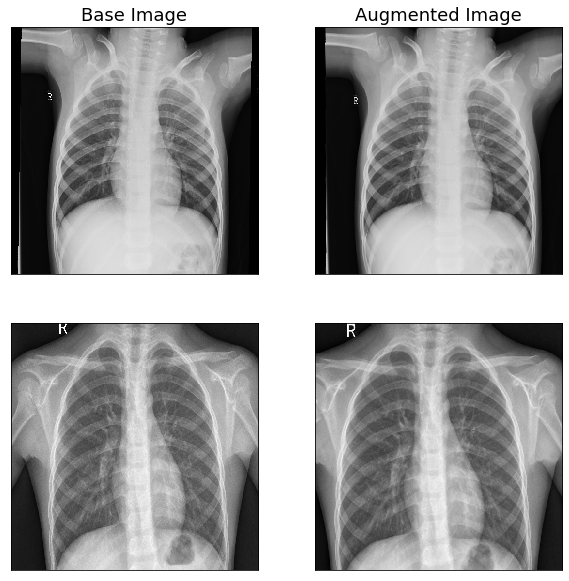

In [13]:
from tensorflow.keras.preprocessing.image import array_to_img

fig, axes = plt.subplots(2, 2)

for i in range(2):
    axes[i, 0].imshow(array_to_img(images_to_augment[i]), 
                      interpolation='nearest')
    
    axes[i, 1].imshow(array_to_img(images_augmented[i]), 
                      interpolation='nearest')
    
    axes[i, 0].set_xticks([])
    axes[i, 1].set_xticks([])
    
    axes[i, 0].set_yticks([])
    axes[i, 1].set_yticks([])
    
columns = ['Base Image', 'Augmented Image']
for ax, column in zip(axes[0], columns):
    ax.set_title(column) 
    
plt.show()

And below is how I used the *prefetch* method of the *tf.Dataset* class that I talked about.

In [14]:
def feed_data(dataset):
    """Feed data to a model with prefetching
    
    Arguments:
        dataset (tf.Dataset): A dataset that to be fed to the model
        
    Returns:
        dataset (tf.Dataset): A prefetched dataset
    """
    
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)  
    
    return dataset

In [15]:
# Define the CNN Keras model
def create_model():
    """
    Create a model
    
    Returns:
        model (tf.keras.Model): An instance of Model
    """
    
    # Model input
    input_layer = layers.Input(shape=(512, 512, 1), name='input')    

    # First block
    x = layers.Conv2D(filters=64, kernel_size=3, 
                      activation='relu', padding='same', 
                      name='conv2d_1')(input_layer)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_1')(x)
    x = layers.Dropout(0.1, name='dropout_1')(x)
    
    # Second block
    x = layers.Conv2D(filters=96, kernel_size=3, 
                      activation='relu', padding='same', 
                      name='conv2d_2')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_2')(x)
    x = layers.Dropout(0.1, name='dropout_2')(x)

    # Third block
    x = layers.Conv2D(filters=128, kernel_size=3, 
                      activation='relu', padding='same', 
                      name='conv2d_3')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_3')(x)
    x = layers.Dropout(0.1, name='dropout_3')(x)
    
    # Fourth block
    x = layers.Conv2D(filters=160, kernel_size=3, 
                      activation='relu', padding='same', 
                      name='conv2d_4')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_4')(x)
    x = layers.Dropout(0.1, name='dropout_4')(x)

    # Fifth block
    x = layers.Conv2D(filters=192, kernel_size=3, 
                      activation='relu', padding='same', 
                      name='conv2d_5')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_5')(x)
    x = layers.Dropout(0.1, name='dropout_5')(x)
    
    # Sixth block
    x = layers.Conv2D(filters=224, kernel_size=3, 
                      activation='relu', padding='same', 
                      name='conv2d_6')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_6')(x)
    x = layers.Dropout(0.1, name='dropout_6')(x)
    
    # Seventh block
    x = layers.Conv2D(filters=256, kernel_size=3, 
                      activation='relu', padding='same', 
                      name='conv2d_7')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_7')(x)
    x = layers.Dropout(0.1, name='dropout_7')(x)

    # Pooling and output
    x = layers.GlobalAveragePooling2D(name='global_average_pooling2d')(x)    
    output = layers.Dense(units=1, 
                          activation='sigmoid', 
                          name='output')(x)

    # Model creation and compilation
    
    model = Model (input_layer, output)    
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    return model

In [16]:
# Create a Model object
model = create_model()

In [17]:
# See the layer and parameter summary
#model.summary()

In [18]:
from tensorflow.keras.utils import plot_model

# See graphical representation of the model
#plot_model(model, show_shapes=True)

In [19]:
# Load the weights of a pretrained model
model.load_weights('../../D2/7-layer_double_adam_512_aug_bn_dropout01_explr_0200_D2.hdf5')

In [20]:
# Evaluate the model on the test set
test_steps = test_gen.samples // BATCH_SIZE
model.evaluate(test_data, steps=test_steps)

# Declare an image generator on test data for augmented images
test_aug_gen = datagen.flow_from_dataframe(test_df,
                                           target_size=(512, 512),
                                           color_mode='grayscale',
                                           batch_size=BATCH_SIZE,
                                           class_mode='binary',
                                           shuffle=False)

test_aug_data = tf.data.Dataset.from_generator(lambda: test_aug_gen,
                                           output_types=(tf.float32, tf.int32),
                                           output_shapes=([None, 512, 512, 1], [None, ]))

# Evaluate the model on augmented test data
test_aug_steps = test_aug_gen.samples // BATCH_SIZE
model.evaluate(test_aug_data, steps=test_aug_steps)

8/8 [==============================] - 7s 559ms/step - loss: 0.2560 - accuracy: 0.8887
Found 566 validated image filenames belonging to 2 classes.
8/8 [==============================] - 14s 2s/step - loss: 0.3078 - accuracy: 0.8809


[0.3078451454639435, 0.880859375]

In [21]:
# Calculate precision and recall based on  test data
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()


predictions = model.predict(test_data, steps=test_steps).flatten()
y_true = test_gen.classes[:len(predictions)]

precision.update_state(y_true, predictions)
recall.update_state(y_true, predictions)


In [22]:
f_precision = precision.result().numpy()
print('Precision with base test data:', f_precision)
f_recall = recall.result().numpy()
print('Recall with base test data:', f_recall)
print('F1-Score with base test data:', 2* (f_precision * f_recall)/(f_precision + f_recall))

Precision with base test data: 0.6265432
Recall with base test data: 0.65909094
F1-Score with base test data: 0.6424050929276444


In [23]:
# Calculate precision and recall based on augmented test data

precision.reset_states()
recall.reset_states()

predictions_aug = model.predict(test_aug_data, steps=test_steps).flatten()
y_true = test_gen.classes[:len(predictions_aug)]

precision.update_state(y_true, predictions_aug)
recall.update_state(y_true, predictions_aug)

In [24]:
print('Precision with augmented test data:', precision.result().numpy())
print('Recall with augmented test data:', recall.result().numpy())
print('F1-Score with base test data:', 2* (precision.result().numpy() * recall.result().numpy())/(precision.result().numpy() + recall.result().numpy()))

Precision with augmented test data: 0.62322944
Recall with augmented test data: 0.71428573
F1-Score with base test data: 0.6656581303381762


In [25]:
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_true, predictions > 0.5)

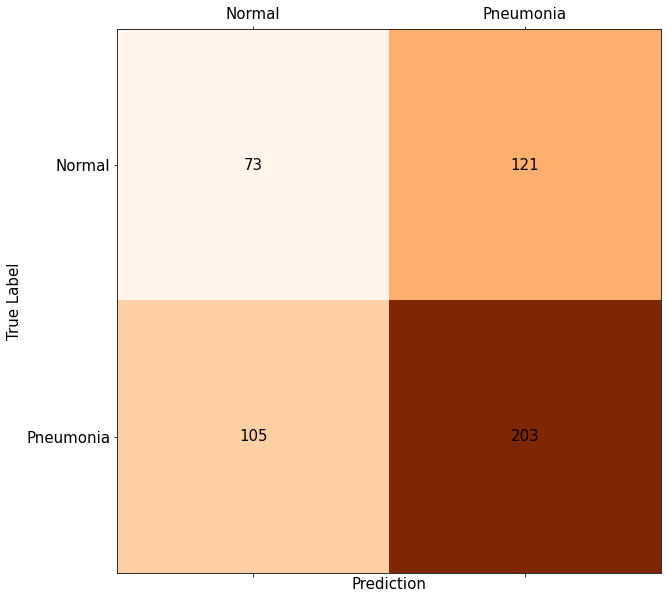

In [26]:
fig, ax = plt.subplots()

ax.matshow(confusion_mat, cmap=plt.cm.Oranges)

ax.set_xlabel('Prediction')
ax.set_ylabel('True Label')

tick_labels = ['Normal', 'Pneumonia']

ax.set_xticks(range(len(tick_labels)))
ax.set_yticks(range(len(tick_labels)))
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)

for i in range(len(tick_labels)):
    for j in range(len(tick_labels)):
        ax.text(j, i, confusion_mat[i, j],
               ha='center', va='center')
        
plt.show()